# Install requirements

## Approach 1: directly

In [1]:
!pip install accelerate==0.30.1 datasets==2.19.1 matplotlib==3.7.1 numpy==1.25.2 scikit-learn==1.2.2 transformers==4.41.0

## Approach 2: using requirements.txt

In [ ]:
!pip install -r requirements.txt

# Import Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from datasets import load_dataset
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
from transformers import (DataCollatorForSeq2Seq, T5ForConditionalGeneration,
                          T5Tokenizer, Trainer, TrainingArguments)

# Define constants

In [3]:
N_SOFT_PROMPT = 10 # number of tokens of soft prompt
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.01
TRAIN_LOG = 100
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


# Load the model & tokenizer

In [4]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small').to(DEVICE)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Load & preprocess dataset

In [5]:
dataset = load_dataset('stanfordnlp/imdb')
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [6]:
class Labels:
    def __init__(self, labels):
        self.labels = labels
        self.label_to_id_dict = {l:i for (i, l) in enumerate(self.labels)}
        self.id_to_label_dict = {i:l for (i, l) in enumerate(self.labels)}

    def convert_labels_to_ids(self, labels):
        return [self.label_to_id_dict.get(l, 2) for l in labels]

    def convert_ids_to_labels(self, ids):
        return [self.id_to_label_dict.get(i, 'other') for i in ids]

imdb_labels = Labels(['negative', 'positive'])

In [7]:
def split_data(data, train_size, seed=42, shuffle=True):
    if shuffle:
        # Shuffle dataset
        data = data.shuffle(seed)
    data_idx = int(len(data) * train_size)
    train_dataset = data.select(range(data_idx))
    eval_dataset = data.select(range(data_idx, len(data)))
    return train_dataset, eval_dataset

def preprocess_function(example):
    # Prepend padding to input with the length same as soft prompts
    pad_token = tokenizer.pad_token
    padded = [pad_token * N_SOFT_PROMPT + t for t in example['text']]
    # Tokenize input text
    model_input = tokenizer(padded, max_length=256, truncation=True)
    # Convert labels to their string format
    label_str = imdb_labels.convert_ids_to_labels(example['label'])
    # Tokenize converted label
    label_tokenized = tokenizer(label_str, max_length=10, truncation=True)
    model_input['labels'] = label_tokenized.input_ids
    return model_input

# Preprocess data
train_dataset = dataset['train'].map(preprocess_function, batched=True)
test_dataset = dataset['test'].map(preprocess_function, batched=True)

# Keep 20% of data as validation set
train_size = 0.8
train_dataset, eval_dataset = split_data(train_dataset, train_size)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
eval_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [8]:
col_fn = DataCollatorForSeq2Seq(
    tokenizer, return_tensors='pt', padding='longest',
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=col_fn,
    shuffle=True
)
eval_loader = torch.utils.data.DataLoader(
    eval_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=col_fn,
    shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=col_fn,
    shuffle=False
)

# Define custom embedding layer
As explained in the [paper](https://https://arxiv.org/abs/2104.08691), we need to prepend soft prompt tokens to the original embeddings. To do so, we defined CustomEmbeddingLayer which initiliazes soft prompts randomly (another approach is to initialize with vocabulary embeddings, but it is not done here). Soft prompt could have arbitrary number of tokens but the tokens embeddings shape should be the same as original embeddings. In forward method, we have to concatenate soft prompts and original embeddings.

In [9]:
class CustomEmbeddingLayer(nn.Module):
    def __init__(self, original_embedding, n_prompts):
        super(CustomEmbeddingLayer, self).__init__()
        self.original_embedding = original_embedding
        self.n_prompts = n_prompts # Number of tokens added as soft prompt
        # Initialize soft prompts
        self.soft_prompts = nn.parameter.Parameter(self.initialize_prompt())

    def initialize_prompt(self, initialize_from_vocab=True):
        if initialize_from_vocab:
            return self.original_embedding.weight[:self.n_prompts]
        else:
            return torch.randn(self.n_prompts, self.original_embedding.embedding_dim)

    def forward(self, input_ids):
        original_embeds = self.original_embedding(input_ids)
        batch_size = input_ids.size(0)
        # Expand soft prompts size to batch size
        soft_prompt_embeds = self.soft_prompts.unsqueeze(0).expand(batch_size, -1, -1)
        embeds_without_pad = original_embeds[:, self.n_prompts:]
        return torch.cat([soft_prompt_embeds, embeds_without_pad], dim=1)


In [10]:
def change_model_embedding(model):
    encoder = model.get_encoder()
    embedding_layer = encoder.get_input_embeddings()
    new_embedding_layer = CustomEmbeddingLayer(embedding_layer, N_SOFT_PROMPT)
    encoder.set_input_embeddings(new_embedding_layer)

change_model_embedding(model)

In [11]:
print(model)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): CustomEmbeddingLayer(
      (original_embedding): Embedding(32128, 512)
    )
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out

# Freeze other parameters
We want to freeze all layers except soft prompts, so we set requires_grad to false except for that.

In [12]:
def freeze_params(model, trainable_params):
    for name, param in model.named_parameters():
        param.requires_grad = any(trainable_param in name for trainable_param in trainable_params)

# Freeze all parameters except soft prompts
freeze_params(model, ['soft_prompts'])

# Train loop

In [13]:
def train_one_epoch(loader, model, optimizer):
    running_loss = 0

    model.train()
    for batch, data in enumerate(tqdm(loader)):
        optimizer.zero_grad()

        data = data.to(DEVICE)
        output = model(**data)
        batch_loss = output.loss

        batch_loss.backward()
        optimizer.step()

        running_loss += batch_loss.item()

        if (batch+1) % TRAIN_LOG == 0:
            print(f'  batch {batch+1} loss: {batch_loss.item():.2f}')

    running_loss /= len(loader)
    return running_loss

# Validation loop

In [14]:
def post_process(data):
    # Convert token ids to words
    data = tokenizer.batch_decode(data, skip_special_tokens=True)
    # Convert words to class labels
    data = imdb_labels.convert_labels_to_ids(data)
    return data

def val_one_epoch(loader, model, optimizer):
    predictions = []
    labels = []
    running_loss = 0

    model.eval()
    with torch.no_grad():
        for batch, data in enumerate(tqdm(loader)):
            data = data.to(DEVICE)
            output = model(**data)
            # Calculate loss
            batch_loss = output.loss
            running_loss += batch_loss.item()
            # Generate model prediction
            pred = model.generate(input_ids=data.input_ids, attention_mask=data.attention_mask, max_new_tokens=10)
            predictions.extend(pred)
            labels.extend(data.labels)

    predictions = post_process(predictions)
    labels = post_process(labels)

    acc = accuracy_score(y_true=labels, y_pred=predictions)
    running_loss /= len(loader)
    return {"loss": running_loss, "accuracy": acc}

In [15]:
def train_val_loop(train_loader, val_loader, model, optimizer):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(EPOCHS):
        print(f'EPOCH {epoch + 1}:')

        train_loss = train_one_epoch(train_loader, model, optimizer)
        val_dict = val_one_epoch(val_loader, model, optimizer)
        val_loss, val_acc = val_dict['loss'], val_dict['accuracy']
        print(f'Loss train {train_loss:.2f}, Loss validation {val_loss:.2f}, Accuracy validation {val_acc:.4f}')

        # Check if the current validation loss is the best we've seen so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # Save the model
            torch.save(model.state_dict(), 'best_model.pth')

        train_losses.append(train_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
train_losses, val_losses = train_val_loop(train_loader, eval_loader, model, optimizer)

EPOCH 1:


  0%|          | 0/625 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/data/data_collator.py:646: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)


  batch 100 loss: 12.84
  batch 200 loss: 11.20
  batch 300 loss: 10.24
  batch 400 loss: 9.40
  batch 500 loss: 8.53
  batch 600 loss: 6.00


  0%|          | 0/157 [00:00<?, ?it/s]

Loss train 10.23, Loss validation 3.55, Accuracy validation 0.0000
EPOCH 2:


  0%|          | 0/625 [00:00<?, ?it/s]

  batch 100 loss: 2.43
  batch 200 loss: 1.40
  batch 300 loss: 0.90
  batch 400 loss: 0.64
  batch 500 loss: 0.53
  batch 600 loss: 0.41


  0%|          | 0/157 [00:00<?, ?it/s]

Loss train 1.35, Loss validation 0.26, Accuracy validation 0.7658
EPOCH 3:


  0%|          | 0/625 [00:00<?, ?it/s]

  batch 100 loss: 0.43
  batch 200 loss: 0.58
  batch 300 loss: 0.34
  batch 400 loss: 0.44
  batch 500 loss: 0.38
  batch 600 loss: 0.35


  0%|          | 0/157 [00:00<?, ?it/s]

Loss train 0.40, Loss validation 0.25, Accuracy validation 0.7572
EPOCH 4:


  0%|          | 0/625 [00:00<?, ?it/s]

  batch 100 loss: 0.35
  batch 200 loss: 0.23
  batch 300 loss: 0.48
  batch 400 loss: 0.32
  batch 500 loss: 0.34
  batch 600 loss: 0.31


  0%|          | 0/157 [00:00<?, ?it/s]

Loss train 0.33, Loss validation 0.23, Accuracy validation 0.7678
EPOCH 5:


  0%|          | 0/625 [00:00<?, ?it/s]

  batch 100 loss: 0.26
  batch 200 loss: 0.36
  batch 300 loss: 0.30
  batch 400 loss: 0.26
  batch 500 loss: 0.24
  batch 600 loss: 0.28


  0%|          | 0/157 [00:00<?, ?it/s]

Loss train 0.30, Loss validation 0.23, Accuracy validation 0.7814
EPOCH 6:


  0%|          | 0/625 [00:00<?, ?it/s]

  batch 100 loss: 0.26
  batch 200 loss: 0.25
  batch 300 loss: 0.21
  batch 400 loss: 0.43
  batch 500 loss: 0.29
  batch 600 loss: 0.30


  0%|          | 0/157 [00:00<?, ?it/s]

Loss train 0.29, Loss validation 0.22, Accuracy validation 0.7876
EPOCH 7:


  0%|          | 0/625 [00:00<?, ?it/s]

  batch 100 loss: 0.26
  batch 200 loss: 0.21
  batch 300 loss: 0.51
  batch 400 loss: 0.33
  batch 500 loss: 0.24
  batch 600 loss: 0.25


  0%|          | 0/157 [00:00<?, ?it/s]

Loss train 0.28, Loss validation 0.22, Accuracy validation 0.7934
EPOCH 8:


  0%|          | 0/625 [00:00<?, ?it/s]

  batch 100 loss: 0.24
  batch 200 loss: 0.27
  batch 300 loss: 0.29
  batch 400 loss: 0.23
  batch 500 loss: 0.23
  batch 600 loss: 0.24


  0%|          | 0/157 [00:00<?, ?it/s]

Loss train 0.28, Loss validation 0.21, Accuracy validation 0.7998
EPOCH 9:


  0%|          | 0/625 [00:00<?, ?it/s]

  batch 100 loss: 0.22
  batch 200 loss: 0.42
  batch 300 loss: 0.25
  batch 400 loss: 0.35
  batch 500 loss: 0.17
  batch 600 loss: 0.29


  0%|          | 0/157 [00:00<?, ?it/s]

Loss train 0.28, Loss validation 0.22, Accuracy validation 0.8010
EPOCH 10:


  0%|          | 0/625 [00:00<?, ?it/s]

  batch 100 loss: 0.25
  batch 200 loss: 0.35
  batch 300 loss: 0.31
  batch 400 loss: 0.30
  batch 500 loss: 0.27
  batch 600 loss: 0.32


  0%|          | 0/157 [00:00<?, ?it/s]

Loss train 0.30, Loss validation 0.21, Accuracy validation 0.8074


# Plot loss curve

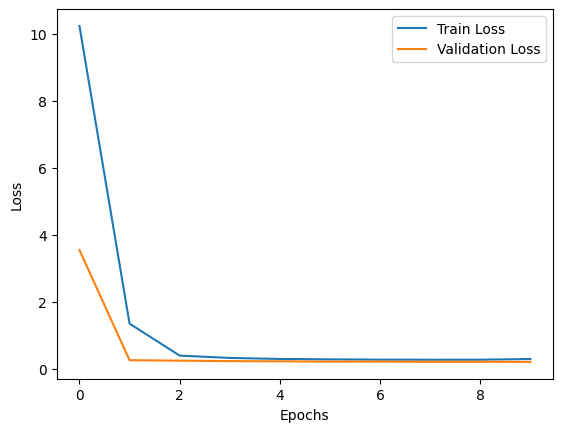

In [16]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_losses(train_losses, val_losses)

# Evaluate on test set

In [19]:
# Load the best model for test dataset
model.load_state_dict(torch.load('best_model.pth'))

test_acc = val_one_epoch(test_loader, model, optimizer)['accuracy']
print(f"Accuracy test {test_acc:.2f}")

  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy test 0.81
